# In this notebook we compute STA (Spike Triggered Average) to estimate the positions of neurons

In [1]:
import sys
import pathlib
sys.path.insert(0, str(pathlib.Path("").resolve().parent)) #.. this has to be the folder reCNN_visual_prosthesis
from models import reCNN_bottleneck_CyclicGauss3d
import matplotlib.pyplot as plt
from Antolik_dataset import AntolikDataset, AntolikDataModule
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import pathlib
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from Antolik_dataset import AntolikDataModule

In [2]:
ENTITY = "csng-cuni"
PROJECT = "reCNN_visual_prosthesis"
ground_truth_positions_file_path = "data/antolik/position_dictionary.pickle"
ground_truth_orientations_file_path = "data/antolik/oris.pickle"

model = None

config = {
    # GENERAL
    "seed": 2,
    "batch_size": 10,
    "lr": 0.01,
    "max_epochs": 80,

    # CORE GENERAL CONFIG
    "core_hidden_channels": 8,
    "core_layers": 5,
    "core_input_kern": 9,
    "core_hidden_kern": 9,

    # ROTATION EQUIVARIANCE CORE CONFIG
    "num_rotations": 8,       
    "stride": 1,               
    "upsampling": 2,           
    "rot_eq_batch_norm": True, 
    "stack": -1 ,               
    "depth_separable": True,

    # READOUT CONFIG
    "readout_bias": True, ###################################################### TODOOOOOOOOOOOOOOOOOOO
    "nonlinearity": "softplus",
    
    # REGULARIZATION
    "core_gamma_input": 0.00307424496692959,
    "core_gamma_hidden": 0.28463619129195233,
    "readout_gamma": 0.17,
    "input_regularizer": "LaplaceL2norm", # for RotEqCore - default 
    "use_avg_reg": True,

    "reg_readout_spatial_smoothness": 0.0027,
    "reg_group_sparsity": 0.1,
    "reg_spatial_sparsity": 0.45,

    # TRAINER
    "patience": 7,
    "train_on_val": False, # in case you want to quickly check that your model "compiles" correctly
    "test": True,
    "observed_val_metric": "val/corr",

    "test_average_batch": False,
    "compute_oracle_fraction": False,
    "conservative_oracle": True,
    "jackknife_oracle": True,
    "generate_oracle_figure": False,

    # ANTOLIK
    "region": "region1",
    "dataset_artifact_name": "Antolik_dataset:latest",

    # BOTTLENECK
    "bottleneck_kernel": 15,

    "fixed_sigma": False,
    "init_mu_range": 0.5,
    "init_sigma_range": 0.5,
    "ground_truth_positions_file_path": "data/antolik/positions_reparametrized.pickle",
    "ground_truth_orientations_file_path": "data/antolik/oris_reparametrized.pickle",
}

path_train = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized/one_trials.pickle"
path_test = "/storage/brno2/home/mpicek/reCNN_visual_prosthesis/data/antolik_reparametrized/ten_trials.pickle"

dataset_config = {
    
    "train_data_dir": path_test,
    "test_data_dir": path_test,
    "batch_size": config["batch_size"],
    "normalize": True,
    "val_size": 500,
    "brain_crop": None,
    "stimulus_crop": None,
    # "brain_crop": 1.5,
    # "stimulus_crop": "auto",
    # "stimulus_crop": [80, 80],
    "ground_truth_path": config["ground_truth_positions_file_path"],
}

dm = AntolikDataModule(**dataset_config)

In [3]:
dm.prepare_data()
dm.setup()

Data loaded successfully!


In [4]:
dm.get_output_shape()

torch.Size([5000])

In [5]:
d = AntolikDataset(path_train)
indices = d.get_indices()
print(indices[0])

0


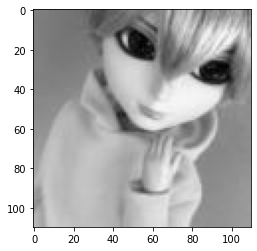

In [6]:
d.visualize(indices[69])

# Compute STA

In [7]:
neurons = 10
result = np.zeros((neurons, 1, 110, 110))
for neu in range(neurons):
    for i in indices:
        stimulus, response = d[i]
        stimulus = stimulus.numpy()
        response = response.numpy()
        result[neu] += response[neu] * stimulus

    print("#", end="")


##########

### And visualize them

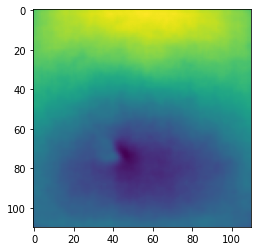

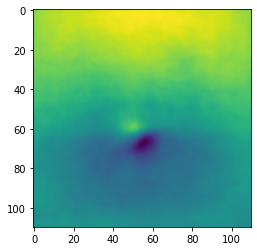

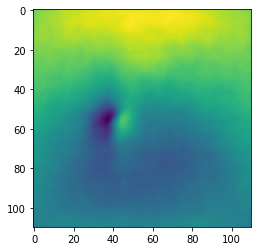

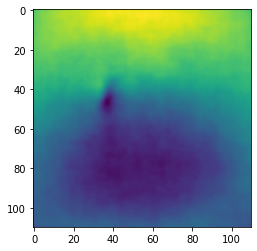

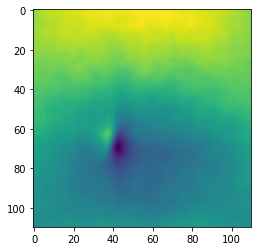

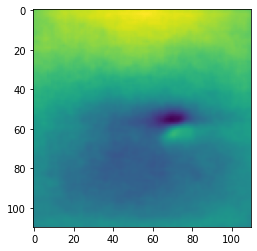

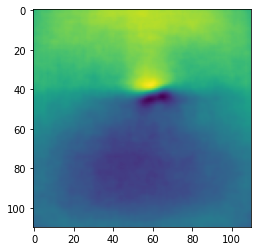

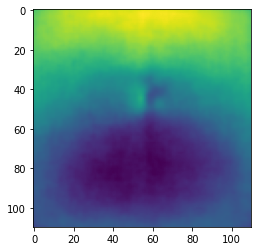

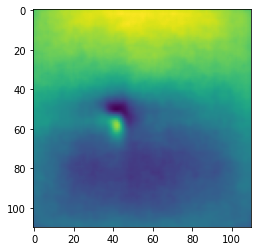

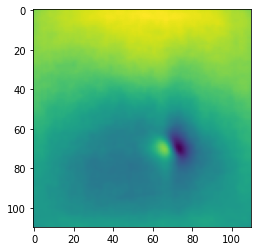

In [8]:
for neu in range(neurons):
    plt.clf()
    plt.imshow(result[neu][0])
    plt.show()

## Now compute the neuron's position by the following:
 1. firstly we filter the image with edge detector kernel
 2. then we find the "maximal edge" = greatest gradient
   - **and this is our estimate of the neuron's position**

[72, 42]


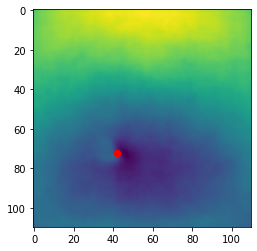

[64, 54]


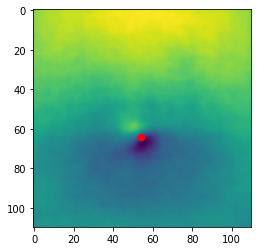

[54, 42]


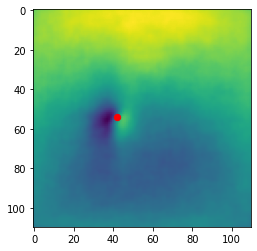

[44, 35]


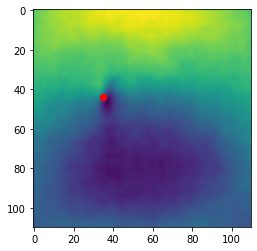

[66, 40]


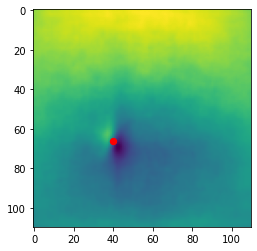

[58, 72]


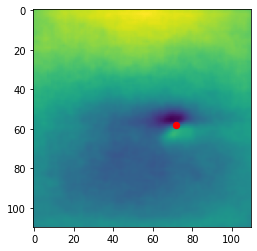

[41, 60]


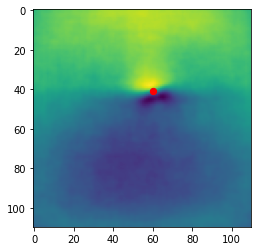

[44, 56]


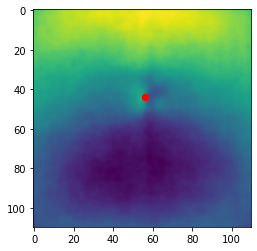

[56, 44]


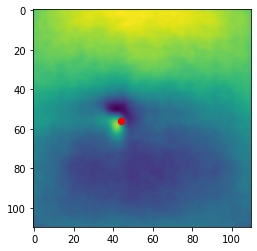

[70, 70]


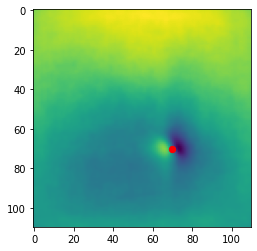

In [9]:
from scipy import ndimage
from skimage import filters

for num in range(neurons):
    x = result[num][0]- result[num][0].min() # so that the values in image are positive
    filtered = filters.sobel(x) # filter the image

    # dim = ndimage.measurements.center_of_mass(filtered)
    argmax = filtered.argmax() # finds the maximum of the flattened array
    position_estimate = [0, 0]
    # we need to find the coordinates in the original image from the position in the flattened array
    position_estimate[0] = argmax//np.shape(x)[-1] 
    position_estimate[1] = argmax%np.shape(x)[-1]
    print(position_estimate)
    
    fig, ax = plt.subplots()
    ax.imshow(x)
    plt.scatter(x=position_estimate[1], y=position_estimate[0], c='r', s=40)
    plt.show()

In [10]:
def cumsum(a):
    c = np.zeros_like(a)
    c[:,0] = a[:,0]
    c[0, :] = a[0, :]

    for i in range(1, a.shape[0]):
        for j in range(1, a.shape[1]):
            c[i, j] = c[i-1, j] + c[i, j-1] + a[i, j]

    return c

### In this approach (not well working one, though) we compute only center of gravity of the STA. That's all. Doesn't work well, however

(40.237301664382315, 54.521094396955625)


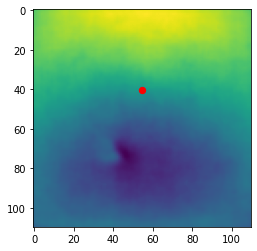

In [11]:
from scipy import ndimage
x = result[0][0]- result[0][0].min()
position_estimate = ndimage.measurements.center_of_mass(x)
print(position_estimate)
fig, ax = plt.subplots()
ax.imshow(x)
plt.scatter(x=position_estimate[1], y=position_estimate[0], c='r', s=40)
plt.show()
